In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("akashshingha850/mrl-eye-dataset")

# print("Path to dataset files:", path)

In [2]:
import os
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm, trange

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# Data Preparation
data_dir = r'C:\Users\leoki\.cache\kagglehub\datasets\akashshingha850\mrl-eye-dataset\versions\4\data'

# Define transformations for the dataset
data_transform = {
        'train' : transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        'val' : transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        'test': transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
    }

phases = ['train', 'val', 'test']

# Create dataset using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x])
                  for x in phases}

# Create Dataloaders to feed data to the model
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4, pin_memory=True) for x in phases}

class_names = image_datasets['train'].classes

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Class names:", class_names)

Using device: cuda
Class names: ['awake', 'sleepy']


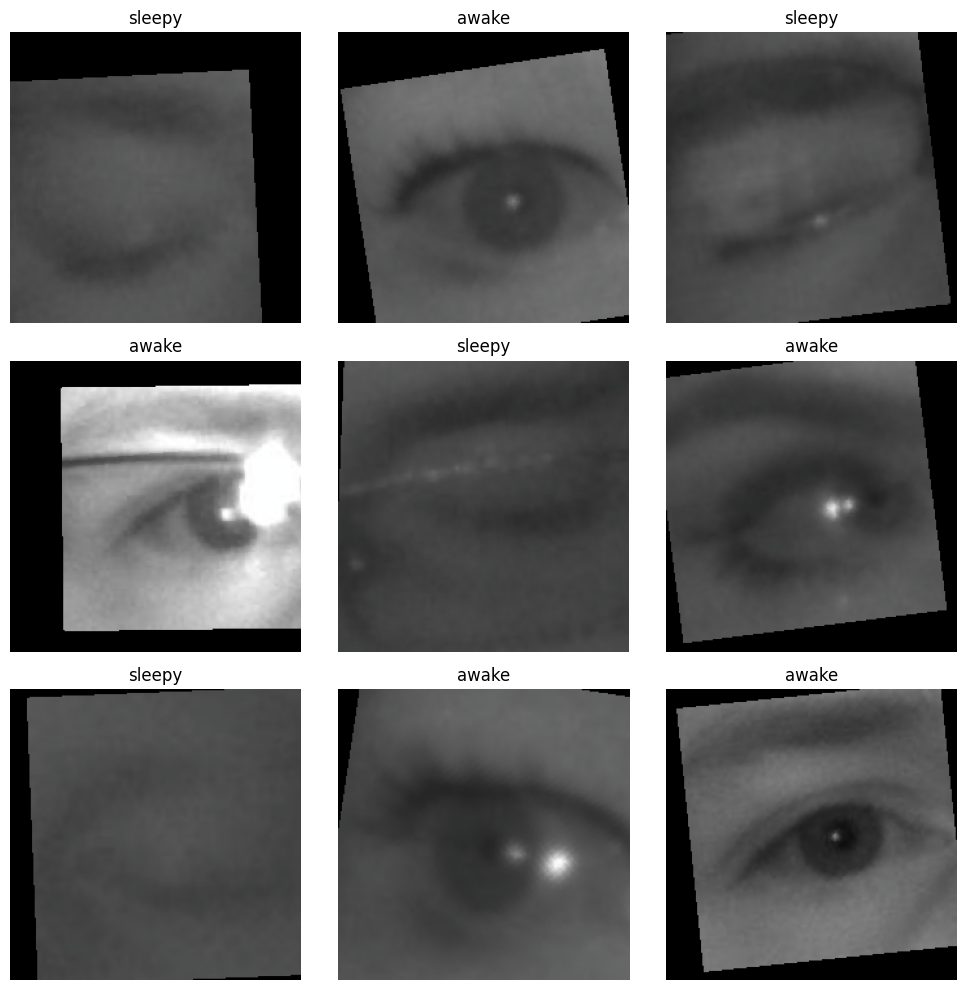

In [4]:
# Get a batch of training data
# Since the dataloader is shuffled, this will be a random batch
inputs, classes = next(iter(dataloaders['train']))

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Mean and std for un-normalization, same as before
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Plot the first 9 images from the batch
for i in range(9):
    # Select the subplot
    ax = axes.flat[i]

    # Get the i-th image tensor
    img = inputs[i]
    
    # --- Un-normalize and format the image for display ---
    img = img.numpy().transpose((1, 2, 0)) # Transpose dimensions
    img = std * img + mean                 # Un-normalize
    img = np.clip(img, 0, 1)               # Clip values to [0, 1] range

    # Display the image
    ax.imshow(img)
    # Set the title to the correct class name
    ax.set_title(class_names[classes[i]])
    # Turn off the axes (ticks and labels)
    ax.axis('off')

# Adjust layout to prevent titles from overlapping and show the plot
plt.tight_layout()
plt.show()

In [5]:
# Model Definition
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers; will only train the final layer
# Want to preserve the general features already learned by the pretrained model & only train the final layer to determine if the eye is open or closed
for param in model.parameters():
    param.requires_grad = False 

num_ftrs = model.fc.in_features

# Replace the final layer with a new one that has 2 outputs (awake/sleepy)
# New params have requires_grad=True by default
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

In [6]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 13  # Increased epochs for more thorough training

epoch_pbar = trange(epochs, desc="Overall Progress")

for epoch in epoch_pbar:
    epoch_metrics = {}
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        phase_pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} - {phase}", leave=False)

        for inputs, labels in phase_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.long())
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        
        epoch_metrics[f'{phase}_loss'] = f"{epoch_loss:.4f}"
        epoch_metrics[f'{phase}_acc'] = f"{epoch_acc:.4f}"

    epoch_pbar.set_postfix(epoch_metrics)

model_path = 'eyenet_model.pth'
torch.save(model.state_dict(), model_path)  # Save the final model state

Overall Progress:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 1 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 2 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 3 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 4 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 5 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 6 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 7 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 7 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 8 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 8 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 9 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 9 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 10 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 10 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 11 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 11 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 12 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 12 - val:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 13 - train:   0%|          | 0/796 [00:00<?, ?it/s]

Epoch 13 - val:   0%|          | 0/266 [00:00<?, ?it/s]

In [7]:
# Test Model
model.load_state_dict(torch.load(model_path))
model.eval()

running_corrects = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
    
test_acc = running_corrects.double() / len(image_datasets['test'])
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9544
